### How to Access MERRA-2 Data using OPeNDAP with Python3 and Calculate Daily/Weekly/Monthly Statistics from Hourly Data 

* This instruction is based on Python3 and demonstrates how to remotely access the Modern-Era Retrospective analysis for Research and Applications, Version 2 (MERRA-2) hourly files via OPeNDAP and analyze data such as resample hourly files into daily, weekly, and monthly files and calculate their corresponding statistics, e.g., mean, sum, maximum, and minimum. 

**Contact**: 
* gsfc-dl-help-disc@mail.nasa.gov
* Last update: Sep. 20, 2021

This Python3 example code demonstrates how to remotely access a dataset archived in GES DISC using the Open-source Project for a Network Data Access Protocol (OPeNDAP) web service. We use the Modern-Era Retrospective analysis for Research and Applications, Version 2 (MERRA-2) aerosol diagnostics collection M2T1NXAER.5.12.4 in this example. This collection is 1-hourly time-averaged single-level global aerosol assimilation and archived in daily files with 24 hourly time slices in each file (481 MB per file/day and 14.6 GB per month). For demonstration, we only read 12-day data (i.e., the first 12 days in January 2020)remotely through OPeNDAP URL. We also demonstrate how to calculate the daily/weekly/monthly statistics from hourly data and visualize the evolution of Australian bushfire in January 2020. Figures 1 and 2 are the example images generated by the Python code below, in which the total aerosol extinction (AOT) is plotted as an indicator of the aerosol loading in atmosphere. 

**Prerequisites** 

- This example code is written in Python3 (v3.9.2) Jupyter Notebook and requires these libraries: xarray (0.17.0), matplotlib.pyplot (3.4.1), cartopy.crs (0.18.0), calendar, time, platform (make sure all packages are up to date). In particular, here is the instruction on how to install [xarray](http://xarray.pydata.org/en/stable/getting-started-guide/installing.html) and [cartopy](https://scitools.org.uk/cartopy/docs/v0.15/installing.html). 
- You can execute this example code in your Jupyter Notebook. This code has been tested with Jupyter Notebook v6.2.0 and v6.3.0 in Mac OS, Jupyter Notebook v6.1.4 in Windows OS. Or you can just run it in your Python 3 enviroment. This code has been tested in Python 3 in Mac, window and Linux OS.

**Caveats**:

- Reading multiple hourly data files is a resource demanding task due to large data volume. It may take about 5 minutes to open one-month of the sample data (or longer if the data archive system is  currently heavily loaded). Be patient!
- Visualizing the figures may also take time (~4 minute)
- You may want to test first if your xarray package can read the data in your local disk before reading the data remotely as demonstrated in this case. 


**Reference**:
- [Time-series in xarray](http://xarray.pydata.org/en/stable/time-series.html) 
- [Statistical Operations, Resampling and Climatologies Using Xarray](https://nci-data-training.readthedocs.io/en/latest/_notebook/climate/1_07_Xarray_statistical_resample_roll_climatology_CMIP6.html)
- [Xarray plotting and visualization](https://xarray-contrib.github.io/xarray-tutorial/scipy-tutorial/04_plotting_and_visualization.html)

**Procedure**:
1. Register Earthdata account and set up the credential environment

2. Execute the Python code below in your Jupyter Notebook step-by-step
- 2.1 Import the required Python modules or libraries. If any of the following import commands fail, check the local Python environment and install any missing packages.

You can run this tutorial in your browser using Colab:<br>

<a target="_blank" href="https://colab.research.google.com/github/OPENDAP/NASA-tutorials/blob/main/tutorials/daac-tutorials/How_to_Access_MERRA2_Using_OPeNDAP_with_Python3_Calculate_Weekly_from_Hourly.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
! pip3 install netCDF4 

In [ ]:
! pip3 install shapely==1.7.1 cartopy xarray h5pyd earthaccess 

### Install Packages and Import Authentication Libraries

In [ ]:
import earthaccess
import os
import platform
from subprocess import Popen
import shutil

### Create EDL files using the `earthaccess`

First, pass your Earthdata credentials to the `earthaccess` library to create the `.netrc` file:

In [ ]:
auth = earthaccess.login(strategy="interactive", persist=True) 

Next, run the following code to generate the `.dodsrc` file, if it is not already present:

In [ ]:
homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .dodsrc to:', homeDir)

# Set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen('chmod og-rw ~/.netrc', shell=True)
else:
    # Copy dodsrc to working directory in Windows  
    shutil.copy2(homeDir + '.dodsrc', os.getcwd())
    print('Copied .dodsrc to:', os.getcwd())

# **PAUSE HERE!**

### Restart your runtime by selecting "Runtime" -> "Restart Runtime"

Then, we will import the rest of the packages:

In [ ]:
# ----------------------
# Import Python modules
# ----------------------
import warnings
warnings.filterwarnings("ignore")

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from calendar import monthrange
import time
import platform
print("platform.python_version() ", platform.python_version())

- 2.2 Remotely access the hourly MERRA-2 files through OPeNDAP URL (Please refer to "How to obtain the URL of OPeNDAP served dataset"). In this case below, we read the first 12 days in January 2020. Note that the collection number was changed to a new number if this collection was reprocessed, please refer to ["Records of MERRA-2 Data Reprocessing and Service Changes"](https://disc.gsfc.nasa.gov/information/documents?title=Records%20of%20MERRA-2%20Data%20Reprocessing%20and%20Service%20Changes). The line of "%%time" at the beginning of each cell is used for estimating the running time for that cell. 

In [2]:
%%time
# ---------------------------------
# Read data
# ---------------------------------
# MERRA-2 collection (hourly)
collection_shortname = 'M2T1NXAER'
collection_longname  = 'tavg1_2d_aer_Nx'
collection_number = 'MERRA2_400'  
MERRA2_version = '5.12.4'
year = 2020
    
# Open dataset
# Read selected days in the same month and year
month = 1  # January
day_beg = 1
day_end = 12
    
# Note that collection_number is MERRA2_401 in a few cases, refer to "Records of MERRA-2 Data Reprocessing and Service Changes"
if year == 2020 and month == 9:
    collection_number = 'MERRA2_401'
            
# OPeNDAP URL 
url = 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/{}.{}/{}/{:0>2d}'.format(collection_shortname, MERRA2_version, year, month)
files_month = ['{}/{}.{}.{}{:0>2d}{:0>2d}.nc4'.format(url,collection_number, collection_longname, year, month, days) for days in range(day_beg,day_end+1,1)]
# Get the number of files
len_files_month=len(files_month)

# Print
print("{} files to be opened:".format(len_files_month))
print("files_month", files_month)

print(" ")  
print("Opening...(It may take ~ 5 minutes to open 1-month data)")
print(" ")
    
# Read dataset URLs
ds = xr.open_mfdataset(files_month)
   
# View metadata (function like ncdump -c)
ds

12 files to be opened:
files_month ['https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200101.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200102.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200103.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200104.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200105.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200106.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tavg1_2d_aer_Nx.20200107.nc4', 'https://goldsmr4.gesdisc.eosdis.nasa.gov/opendap/MERRA2/M2T1NXAER.5.12.4/2020/01/MERRA2_400.tav

<xarray.Dataset>
Dimensions:    (time: 288, lat: 361, lon: 576)
Coordinates:
  * lat        (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lon        (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * time       (time) datetime64[ns] 2020-01-01T00:30:00 ... 2020-01-12T23:30:00
Data variables: (12/50)
    SSSMASS25  (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    DUSCATAU   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    BCSCATAU   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    DUEXTTAU   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    BCFLUXU    (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    OCFLUXV    (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    ...         ...
    SO2SMASS   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    SSANGSTR   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    DUEXTT25   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    OCFLUXU    (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    OCSCATAU   (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
    TOTSCATAU  (time, lat, lon) float32 dask.array<chunksize=(24, 361, 576), meta=np.ndarray>
Attributes: (12/31)
    History:                           Original file generated: Mon Jan 13 21...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_aer_Nx.20200101.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    identifier_product_doi:            10.5067/KLICLTZ8EM9D
    RangeBeginningDate:                2020-01-01
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2020-01-01
    RangeEndingTime:                   23:59:59.000000
    DODS_EXTRA.Unlimited_Dimension:    time

- 2.3 Select your interested variables and extract it from the whole dataset. In this case, we chose "TOTEXTTAU" (Total Aerosol Extinction) at 550nm as an indicator of the aerosol loading in atmosphere.

In [3]:
# ---------------------------------------------------
# Select your interested variable (e.g., TOTEXTTAU)
# ---------------------------------------------------
sel_var_shortname = "TOTEXTTAU"
sel_var_value= ds[sel_var_shortname]
sel_var_longname = sel_var_value.attrs['long_name']
sel_var_unit = '('+sel_var_value.attrs['units']+')' 
print("The selected variable is {}: {}{}".format(sel_var_shortname, sel_var_longname,sel_var_unit))

The selected variable is TOTEXTTAU: Total Aerosol Extinction AOT [550 nm](1)


- 2.4 Calculate the daily/weekly/monthly statistics from hourly data

In [4]:
%%time
# ---------------------------------------------------------------------------------------------------------
# Resample hourly files into daily, weekly, and monthly files and calculate their corresponding statistics,
# e.g., mean, sum, maximum, and minimum.  
# ---------------------------------------------------------------------------------------------------------

# Functions used to calculate various statistics
# ===================================
# Purpose           Function
# 
# mean of dim       mean
# sum of dim        sum
# max of dim        max
# min of dim        min
# ==================================


CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.96 µs


Get the daily mean

In [5]:
%time
# Daily mean (i.e., the averaged value over a day at each grid)
sel_var_daily_mean = sel_var_value.resample(time="1D").mean(dim='time', skipna=True)
sel_var_daily_mean

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


<xarray.DataArray 'TOTEXTTAU' (time: 12, lat: 361, lon: 576)>
dask.array<stack, shape=(12, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-01-12
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4

Get the weekly maximum. Note that it is calendar week, starting from Monday to Sunday of each week. Only available data are counted towards each week. For example, for the first week of 2020, it only counts Jan. 1, 2020 (Wed.), which is the first day read in, to Jan. 5, 2020 (Sun.).

In [6]:
%%time
# Weekly maximum (i.e., the maximum of each week at each grid)
sel_var_weekly_max = sel_var_value.resample(time="1w").max(dim='time', skipna=True)
sel_var_weekly_max

CPU times: user 28.4 ms, sys: 5.29 ms, total: 33.7 ms
Wall time: 36.4 ms


<xarray.DataArray 'TOTEXTTAU' (time: 2, lat: 361, lon: 576)>
dask.array<stack, shape=(2, 361, 576), dtype=float32, chunksize=(1, 361, 576), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-05 2020-01-12
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.5 89.0 89.5 90.0
  * lon      (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4

Get monthly total (it doesn't have any physical meaning for this case, AOT. The sum is useful for mass related variable, such as precipitation)

In [7]:
%%time
# e.g., monthly total (i.e., the total amount over a month at each grid)
# sel_var_monthly_total = sel_var_value.resample(time='m').sum(dim='time', skipna=True)
# sel_var_monthly_total

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


- 2.5 Visualize the evolution of Australian bushfire with maps and time series

1) Plot the spatial map (e.g., the first two weeks). See Figure 1. 

Plotting...(It may take ~ 4 minutes)
 Pick up your figure  ./map.M2T1NXAER.selected_time.TOTEXTTAU.png
CPU times: user 10 s, sys: 6.16 s, total: 16.2 s
Wall time: 8min 9s


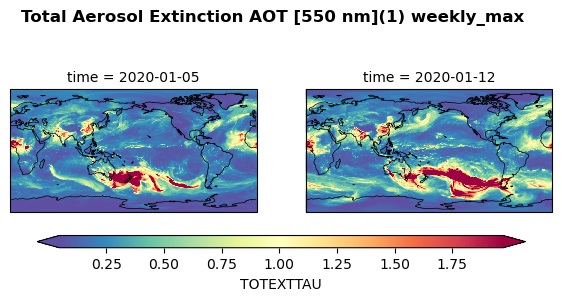

In [8]:
%%time
# ------------------------------------------------------------------
# Visualizing the evolution of Australian bushfire 
# ------------------------------------------------------------------

# 1) Plot the spatial facet map (e.g., the first two weeks)
print("Plotting...(It may take ~ 4 minutes)")

pmap = sel_var_weekly_max.isel(time=[0,1]).plot(transform=ccrs.PlateCarree(),  # the data's projection
             col='time', col_wrap=2, robust=True, # multiplot settings
             cmap=plt.cm.Spectral_r, 
             cbar_kwargs={
            "orientation": "horizontal",
            "shrink": 0.9,
            "aspect": 40,
            "pad": 0.1,
                         },
            subplot_kws={'projection': ccrs.PlateCarree(central_longitude=180)})  # the plot's projection
            # shift the original central longitude from 0 to 180 


# We have to set the map's options on all axes

for ax in pmap.axes.flat:
    ax.coastlines(resolution="110m",linewidth=0.5)
    
# Plot main title
main_title = "{}{} weekly_max".format(sel_var_longname, sel_var_unit) 
plt.suptitle(main_title, fontweight='bold')

# Save the plot 
file_dir = '.'
figFile_plot = "{}/map.{}.selected_time.{}.png".format(file_dir, collection_shortname,sel_var_shortname)
plt.savefig(figFile_plot, dpi=200)
print(" Pick up your figure ", figFile_plot) 

2) Plot the time series of daily mean averaged over the globe (Figure 2)

stat:
       TOTEXTTAU
count  12.000000
mean    0.136681
std     0.011766
min     0.115233
25%     0.129005
50%     0.141344
75%     0.144894
max     0.148424
 Pick up your figure  ./timeseries.M2T1NXAER.selected_time.TOTEXTTAU.png
CPU times: user 1.29 s, sys: 267 ms, total: 1.56 s
Wall time: 637 ms


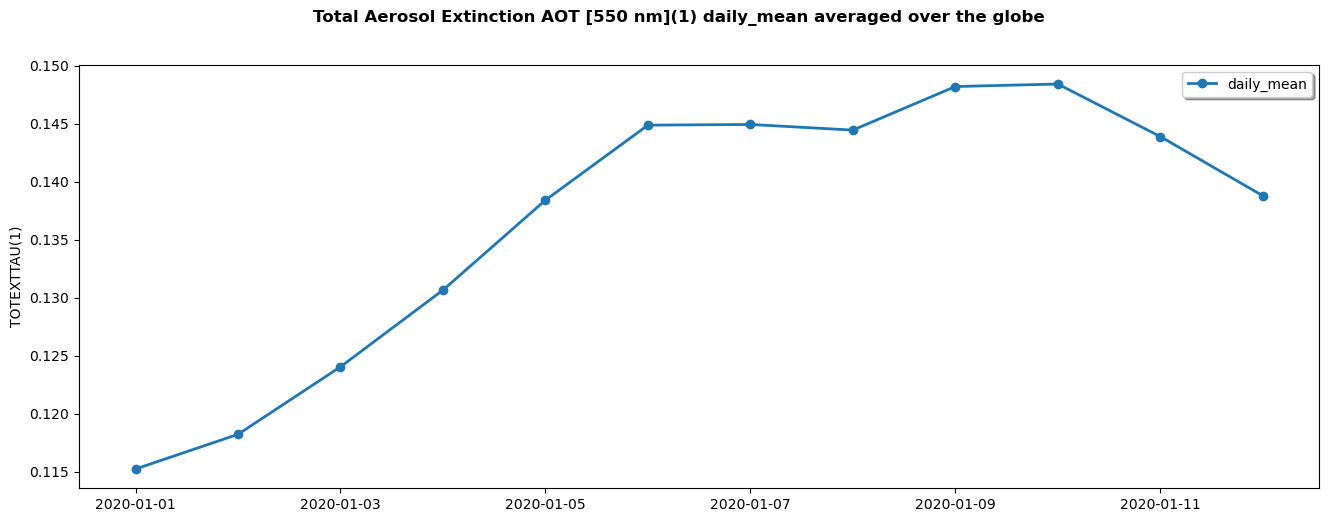

In [9]:
%%time

# 2) Plot the time series of daily mean averaged over the globe 

fig, ax = plt.subplots(figsize=(16,5.5))
sel_var_daily_mean_region = sel_var_daily_mean.groupby('time').mean(dim=['lat','lon'],skipna=True)

# Convert to dataframe 
plotdata = sel_var_daily_mean_region.to_dataframe()

# List the statistics
stat = plotdata.describe()
print("stat:")
print(stat)

# Plot time series
ax.plot(plotdata,label='daily_mean', marker="o", linewidth=2)
ax.legend(shadow=True, fancybox=True)

# Plot main title and xy labels
main_title = "{}{} daily_mean averaged over the globe".format(sel_var_longname, sel_var_unit) 
plt.suptitle(main_title, fontweight='bold')
ax.set_ylabel(sel_var_shortname+sel_var_unit)

# Save the plot
figFile_plot = "{}/timeseries.{}.selected_time.{}.png".format(file_dir, collection_shortname,sel_var_shortname)
plt.savefig(figFile_plot, dpi=200)
print(" Pick up your figure ", figFile_plot) 